# 1. Generate surrogate data and simulate neuron spiking.

In [526]:
from coniii import *
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random

In [527]:
# Define Parameters
T = 3600 # time of simulation
N = 25  # number of neurons
dT = 0.5 # time step
params_assembly_density = 5 # size of neurons in each assembly
params_assembly_num =2 # number of assemblies
params_point_into_neuron_distance = 0.5 
fire_rate_background = np.random.uniform(1, 6, N)

In [535]:
# Function to create a neuron array using unit-spacing hexagonal lattice points neuron
def create_neuron_array(num_neurons):
    coords = []
    num_rows = int(np.sqrt(num_neurons))
    num_cols = num_rows
    for i in range(num_rows):
        for j in range(num_cols):
            x = j + 0.5 * (i % 2)  # Stagger every other row to create hexagonal pattern
            y = i * np.sqrt(3) / 2  # Scale row spacing by sqrt(3)/2 to create hexagonal pattern
            coords.append((x, y))
    return np.array(coords)

In [529]:
# Function to create an assembly of neurons
def create_rough_assembly(neuron_coords, num_points, mean, std_dev):
    # Create the covariance matrix
    cov_matrix = np.eye(2) * std_dev**2
    # Draw points from a two-dimensional normal distribution
    points = np.random.multivariate_normal(mean, cov_matrix, num_points)
    # Find the closest neuron to each drawn point
    distances = cdist(points, neuron_coords)
    closest_neurons = np.argmin(distances, axis=1)
    # If the distance from the neuron to the drawn point is less than 0.5, it is considered part of the assembly
    #Change the parameter because of small size of neurons
    assembly_neurons = neuron_coords[closest_neurons[distances[np.arange(len(closest_neurons)), closest_neurons] < 2]]
    new_assembly_neurons = np.unique(assembly_neurons, axis = 0)

    return new_assembly_neurons

In [530]:
def simpson_coefficient_2d(a, b):

    # Convert arrays to tuples for comparison
    a_tuples = set(map(tuple, a))
    b_tuples = set(map(tuple, b))
    # Find the intersection
    intersection = a_tuples & b_tuples
    # Return the Szymkiewicz-Simpson coefficient
    return len(intersection) / min(len(a_tuples), len(b_tuples))

Number of neurons in assembly:  3
Neurons in assembly:
  [[3.         1.73205081]
 [4.         3.46410162]
 [4.5        2.59807621]]
----------------------------------------------------------------------------------------
Number of neurons in assembly:  5
Neurons in assembly:
  [[1.5        2.59807621]
 [2.5        2.59807621]
 [3.         3.46410162]
 [4.         1.73205081]
 [4.         3.46410162]]
----------------------------------------------------------------------------------------
The 0 and the 1 assembly mean pairwise Szymkiewicz-Simpson coefficient value: 0.33
Which is less than 0.35


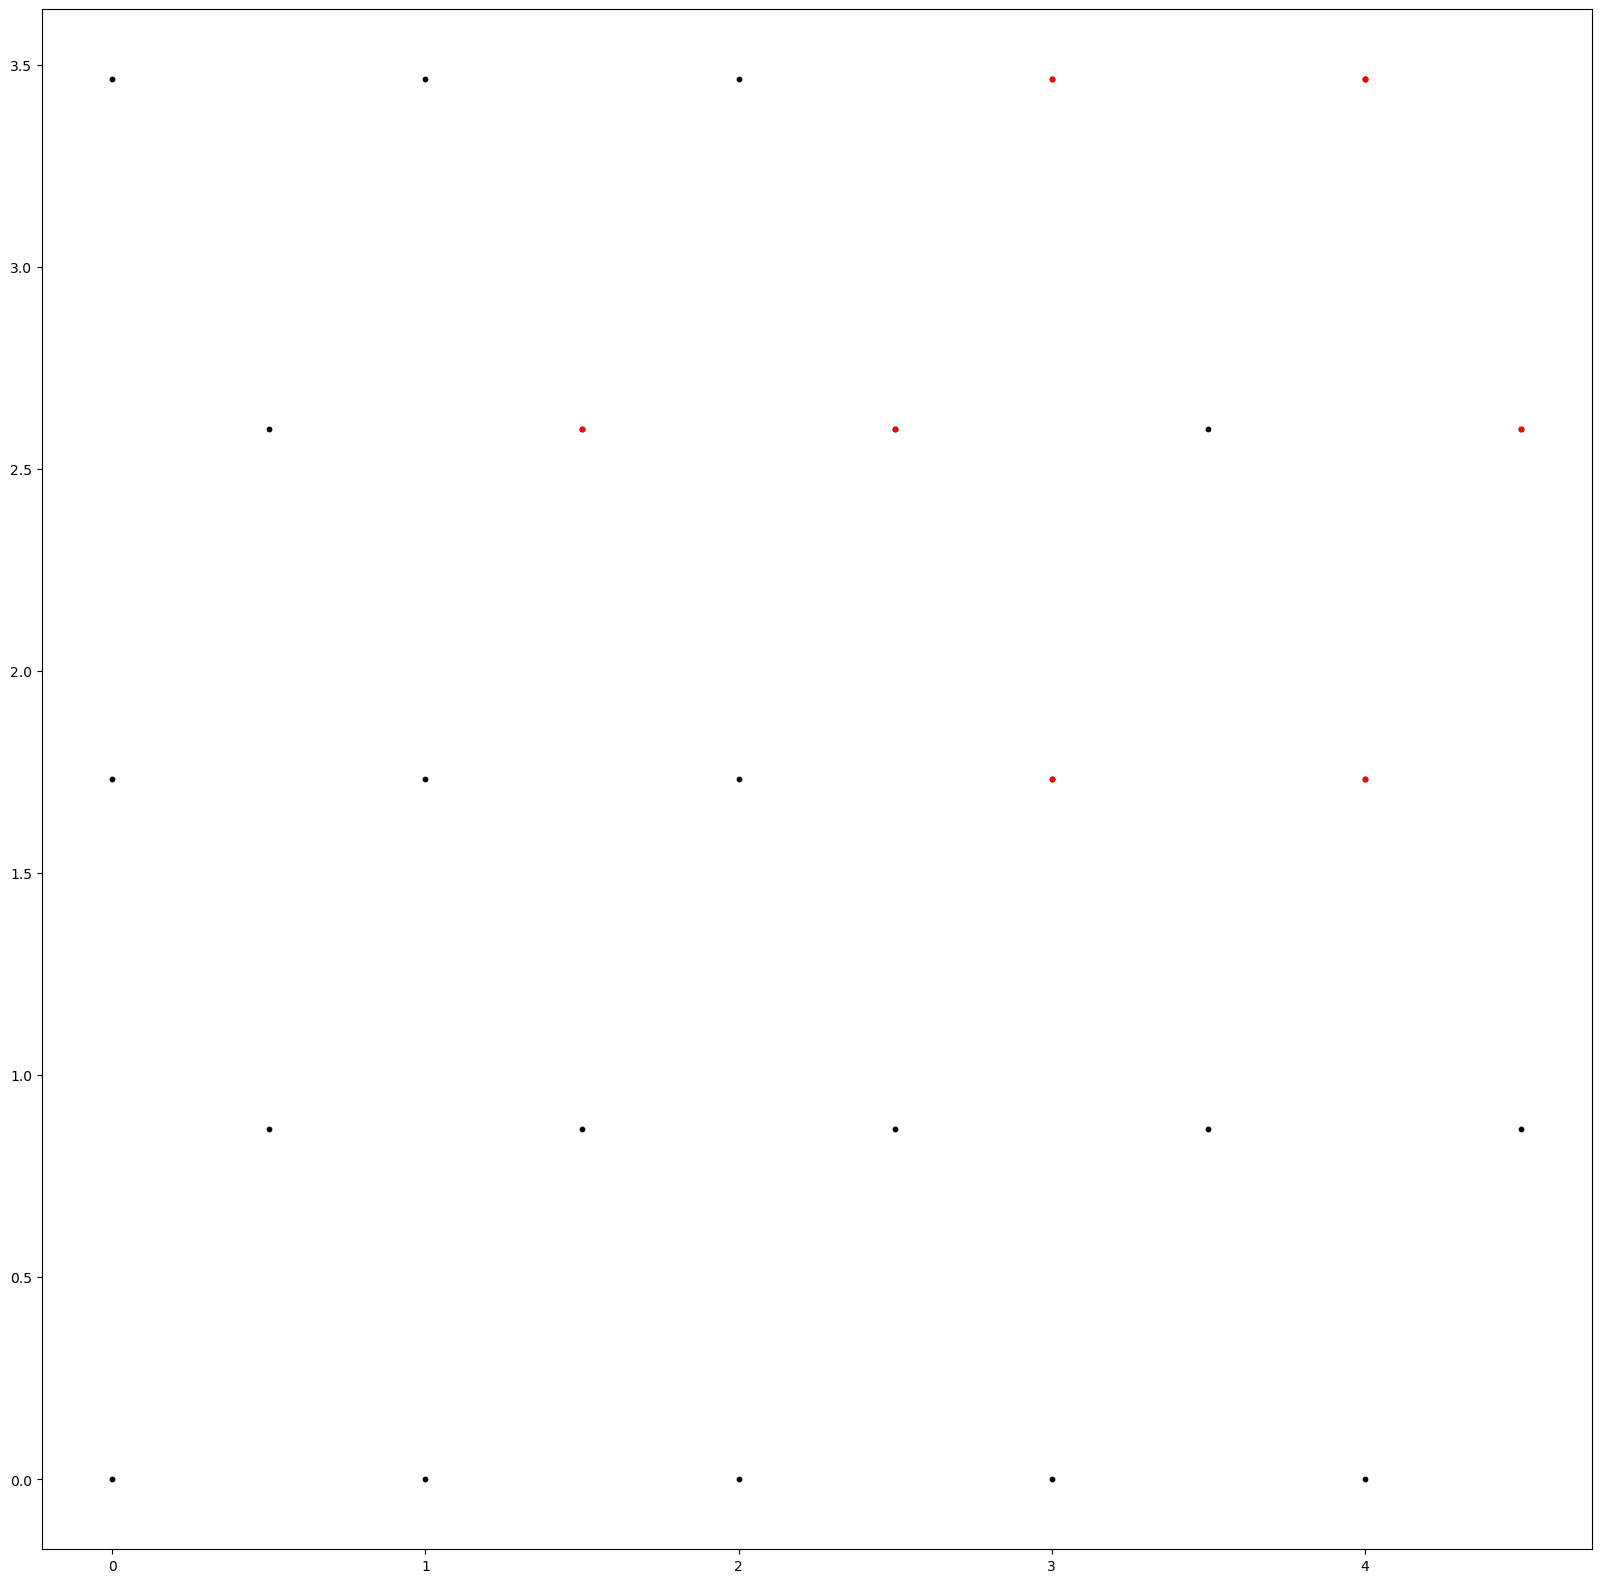

In [546]:
# Generate the neuron array
neuron_array = create_neuron_array(N)
first_time = True

# Generate assemblies
assemblies = []
count = 0
coeff_data = []
for i in range(params_assembly_num):
    while True:
        # Choose a centre from a uniform distribution
        params_distruibution_centre = np.random.uniform(0, 4, size=2)
        # Choose a standard deviation from a uniform distribution
        params_distribution_std_dev = np.random.uniform(1, 3, size=2)
        assembly = create_assembly(neuron_array,params_assembly_density ,params_distruibution_centre, 1)
        # If assembly is not empty, append it to assemblies and break the while loop
        if len(assembly) > 1:
            if first_time:
                first_time = False
                print("Number of neurons in assembly: ", len(assembly))
                print("Neurons in assembly:\n ", assembly)
                print("----------------------------------------------------------------------------------------")
                assemblies.append(assembly)
                break
            else:
                for j in range(i):
                    if (simpson_coefficient_2d(assembly, assemblies[j]) > 0.35 ):
                        break
                    else:
                        coeff_data.append((j, i, simpson_coefficient_2d(assembly, assemblies[j])))
                        count += 1
                if(count == i):
                    #print(coeff_data)
                    print("Number of neurons in assembly: ", len(assembly))
                    print("Neurons in assembly:\n ", assembly)
                    print("----------------------------------------------------------------------------------------")
                    print("The %s and the %s assembly mean pairwise Szymkiewicz-Simpson coefficient value: %.2f"
                          %(coeff_data[0][0], coeff_data[0][1], float(coeff_data[0][2])))
                    print("Which is less than 0.35")
                    assemblies.append(assembly)
                    count = 0
                    break


# Plot the neuron array and assemblies 
plt.figure(figsize=(20, 20))
plt.scatter(neuron_array[:, 0], neuron_array[:, 1], color='black', s=10)
for assembly in assemblies:
    plt.scatter(assembly[:, 0], assembly[:, 1], color='red', s=10)
plt.show()


# Assign firing rate for each neuron

In [547]:
assemblies

[array([[3.        , 1.73205081],
        [4.        , 3.46410162],
        [4.5       , 2.59807621]]),
 array([[1.5       , 2.59807621],
        [2.5       , 2.59807621],
        [3.        , 3.46410162],
        [4.        , 1.73205081],
        [4.        , 3.46410162]])]

In [548]:
# First, generate a dictionary mapping neuron coordinates to indices
coord_to_index = {tuple(coord): i for i, coord in enumerate(neuron_array)}

neuron_array_coord = neuron_array
assemblies_coord = assemblies

# Then, replace the coordinates in the neuron_array with indices
neuron_array = np.array([coord_to_index[tuple(coord)] for coord in neuron_array_coord])



# Finally, replace the coordinates in the assemblies with indices
for i in range(len(assemblies)):
    assemblies[i] = [coord_to_index[tuple(coord)] for coord in assemblies_coord[i] if tuple(coord) in coord_to_index]

print("Thr number of Neuron:" ,N)
print("Neuron array: ", neuron_array)
print("Assemblies: ", assemblies)

Thr number of Neuron: 25
Neuron array:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Assemblies:  [[13, 24, 19], [16, 17, 23, 14, 24]]


In [549]:
import numpy as np
from scipy.stats import poisson

def generateSpikeCountField(N, T, dT, assemblies, rateRange, eventDur, eventProb, eventMult):
    
    """
    Function to generate spike count for a given set of parameters.
    N: Number of neurons
    T: Number of time steps
    dT: Width of a time step in units of seconds
    assemblies: List of collections of units to be combined to assemblies
    rateRange: Range of base firing rate in units of inverse seconds (Hertz)
    eventDur: Length of an active event as a number of timesteps
    eventProb: Probability with which a unit is particularly active in a single timestep
    eventMult: Firing rate multiplier at active events
    """
    
    # Initialization
    fire_rate_background = np.random.uniform(rateRange[0], rateRange[1], size=(T, N))
    activation_field = np.zeros((T, N), dtype=bool)

    # Generate activation for each assembly and each neuron
    for t in range(T):
        for assembly in assemblies:
            # If any neuron in this assembly is activated, all neurons in this assembly are activated 
            if np.any(np.random.rand(len(assembly)) < eventProb):
                activation_field[t, assembly] = True
        # For neurons not in any assembly, they are activated independently
        not_in_assembly = np.setdiff1d(np.arange(N), np.concatenate(assemblies))
        activation_field[t, not_in_assembly] = np.random.rand(len(not_in_assembly)) < eventProb

    # If neuron is activated at a timestep, its firing rate is increased by eventMult times
    fire_rate = np.where(activation_field, fire_rate_background * eventMult, fire_rate_background)
    # Generate Poisson spike count for each neuron at each timestep
    spike_count = np.random.poisson(fire_rate * dT)
    
    return spike_count

In [567]:
import csv
# Length of an active event as a number of timesteps
eventDur = np.random.randint(1, 10)

# Probability with which a unit is particularly active in a single timestep
eventProb = np.random.uniform(0.01, 0.05)

# Firing rate multiplier at active events
eventMult = np.random.uniform(6, 10)  # random number between 1 and 5

print(f'eventDur: {eventDur}, eventProb: {eventProb}, eventMult: {eventMult}')

spikeCount = generateSpikeCountField(N, T, dT, assemblies, (1, 6), eventDur, eventProb, eventMult)

spikeCount = np.where(spikeCount < 6, 0, 1)
ratios = np.mean(spikeCount, axis=1)

print(spikeCount.shape)
print(spikeCount)
print(ratios[:50])
print(np.mean(ratios))

eventDur: 7, eventProb: 0.02103541850389398, eventMult: 7.627106739437381
(3600, 25)
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0.   0.04 0.08 0.   0.12 0.04 0.   0.   0.08 0.04 0.   0.04 0.04 0.
 0.12 0.   0.   0.   0.   0.   0.08 0.08 0.04 0.   0.   0.   0.04 0.
 0.   0.   0.   0.   0.   0.   0.16 0.   0.12 0.04 0.04 0.   0.08 0.08
 0.   0.08 0.12 0.08 0.   0.12 0.   0.32]
0.05585555555555556


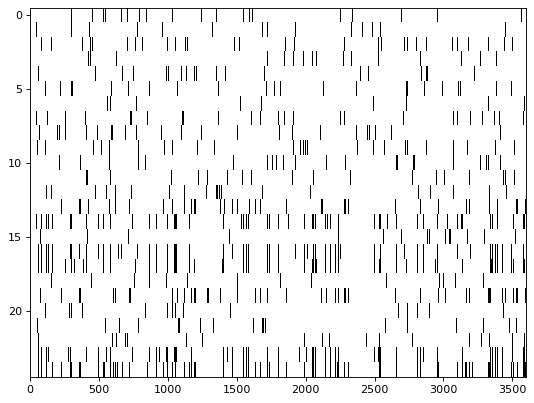

In [569]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(spikeCount.T, aspect="auto", cmap="gray_r", interpolation="none")

In [590]:
es_samples = spikeCount.T
es_samples[es_samples == 0] = -1
solver = ClusterExpansion(es_samples.T)
multipliers, ent, clusters, deltaSdict, deltaJdict= solver.solve(threshold=1e-1, full_output=True)


C:\Users\Riickyyy\anaconda3\envs\coniii\lib\site-packages\coniii\solvers.py:96: UserWarning: Assuming that calc_observables should be for Ising model.
  if iprint: warn("Assuming that calc_observables should be for Ising model.")
C:\Users\Riickyyy\anaconda3\envs\coniii\lib\site-packages\coniii\samplers.py:1187: UserWarning: Boost C++ implementation not available. Defaulting to slower sampling methods.
  warn("Boost C++ implementation not available. Defaulting to slower sampling methods.")


adaptiveClusterExpansion: Clusters of size 2
adaptiveClusterExpansion: Clusters of size 3
adaptiveClusterExpansion: Clusters of size 4


In [597]:
multipliers.shape

(325,)

In [599]:
N = es_samples.shape[0]

J = multipliers[N:]
# constructing the coordinates
coords = [(i, j) for i in range(1, N) for j in range(i+1, N+1)]

# filtering the values and their locations
non_zero_values = [(coords[i], val) for i, val in enumerate(J) if val != 0]

# print the results
for location, value in non_zero_values:
    print(f"Location: {location}, Value: {value}")

Location: (14, 20), Value: 1.0728271519886352
Location: (15, 17), Value: 0.4076904955253492
Location: (15, 18), Value: 0.37601165364689115
Location: (15, 24), Value: 0.34862851150059637
Location: (15, 25), Value: 0.8746276852735608
Location: (17, 18), Value: 0.3527894136265681
Location: (17, 24), Value: 0.3411541988196469
Location: (17, 25), Value: 0.8597379547232274
Location: (18, 24), Value: 0.3027659566637042
Location: (18, 25), Value: 0.9135599180359997
Location: (24, 25), Value: 0.8567315179729896


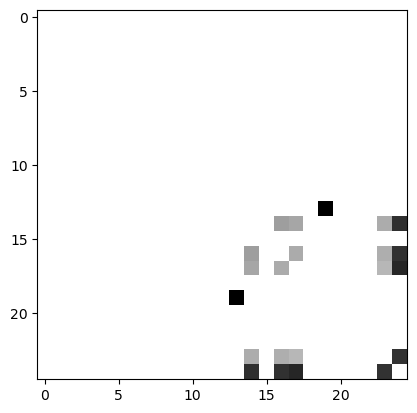

In [600]:


# 创建一个 N*N 的零矩阵
matrix = np.zeros((N, N))

# # 使用数组的前N个元素填充对角线
# matrix[np.diag_indices(FISH_N)] = multipliers[:FISH_N]

# 使用数组的后N+2(N*N-1)个元素填充上半矩阵
index = N
for i in range(N):
    for j in range(i+1, N):
        matrix[i, j] = multipliers[index]
        index += 1
# 获取上半矩阵（包含对角线）
upper_matrix = np.triu(matrix)

# 转置上半矩阵并将其添加到下半部分
lower_matrix = np.transpose(upper_matrix)
lower_matrix = np.tril(lower_matrix, -1)

# 将上半矩阵和转置的下半矩阵相加得到完整的矩阵
final_matrix = upper_matrix + lower_matrix

plt.imshow(final_matrix, cmap='gray_r')

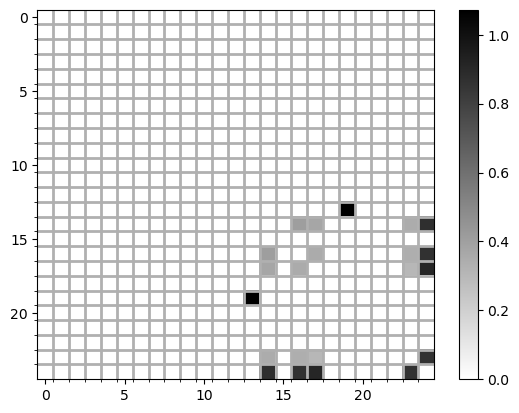

In [601]:
#plot imshow and add lines
plt.imshow(final_matrix, aspect="auto", cmap="gray_r")
ax = plt.gca() # 获取当前的坐标轴
ax.set_xticks([x-0.5 for x in range(1, final_matrix.shape[1])], minor=True) # 设置x轴的小刻度
ax.set_yticks([y-0.5 for y in range(1, final_matrix.shape[0])], minor=True) # 设置y轴的小刻度
plt.grid(which='minor', linestyle='-', linewidth=2)
plt.colorbar()